# Association Rules (Market Basket)

In [8]:
import sys, os, warnings
warnings.filterwarnings("ignore")

# project root
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.config import load_config
from src.features.basket import build_basket_matrix, build_basket_subcategory
from src.mining.association import (
    basket_summary,
    top_products,
    find_frequent_itemsets,
    generate_rules,
    filter_top_rules,
    rules_to_csv_friendly,
)

cfg = load_config(os.path.join(ROOT, "configs", "params.yaml"))
assoc_cfg = cfg["association"]

# Load cleaned data
df = pd.read_parquet(os.path.join(ROOT, "data/processed/cleaned.parquet"))
print("Shape:", df.shape)
df.head()

Shape: (9800, 18)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


# 1.Kiểm tra số đơn hàng, số sản phẩm, sparsity

In [ ]:
# Build basket matrix (Order ID × Product Name, 0/1) for top products
basket_product = build_basket_matrix(df, item_col="Product Name")
summary_product = basket_summary(basket_product)
print(f" Tổng quan Market Basket (Product level):")
print(f"   Số đơn hàng  : {summary_product['n_orders']:,}")
print(f"   Số sản phẩm  : {summary_product['n_products']:,}")
print(f"   Sparsity      : {summary_product['sparsity']:.4f}  ({summary_product['sparsity']*100:.2f}%)")

# Build basket by Sub-Category (for Association Rules)
basket = build_basket_subcategory(df)
summary = basket_summary(basket)

print(f"\n Tổng quan Market Basket (Sub-Category level):")
print(f"   → Sử dụng Sub-Category cho Association Rules (giảm sparsity)")
print(f"   Số đơn hàng     : {summary['n_orders']:,}")
print(f"   Sparsity        : {summary['sparsity']:.4f}  ({summary['sparsity']*100:.2f}%)")
print(f"   Số Sub-Category: {summary['n_products']:,}")

📊 Tổng quan Market Basket (Product level):
   Số đơn hàng  : 4,922
   Số sản phẩm  : 1,849
   Sparsity      : 0.9989  (99.89%)

📊 Tổng quan Market Basket (Sub-Category level):
   → Sử dụng Sub-Category cho Association Rules (giảm sparsity)
   Số đơn hàng     : 4,922
   Sparsity        : 0.8926  (89.26%)
   Số Sub-Category: 17


# 2.top sản phẩm bán chạy

,Product Name,order_count
0,Staple envelope,47
1,Staples,46
2,Easy-staple paper,44
3,Avery Non-Stick Binders,20
4,Staple remover,18
5,Staples in misc. colors,18
6,Storex Dura Pro Binders,17
7,KI Adjustable-Height Table,17
8,Staple-based wall hangings,16
9,"Situations Contoured Folding Chairs, 4/Set",15


✅ Saved outputs/tables/top_products.csv
✅ Saved outputs/figures/top_products.png


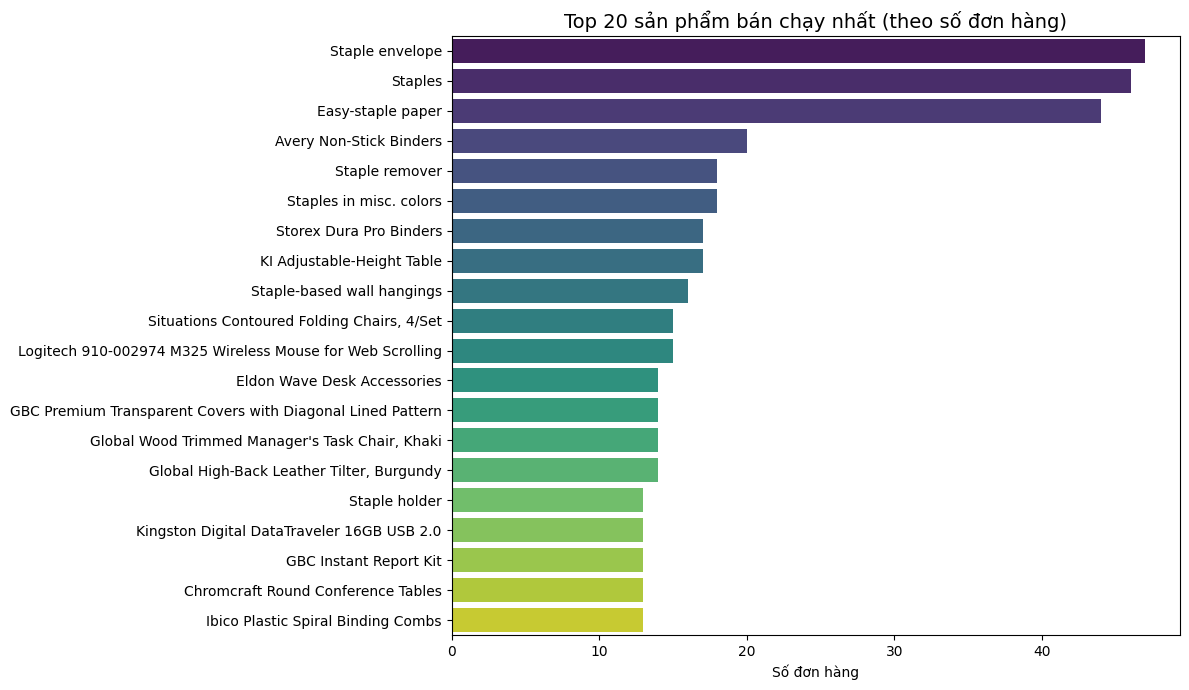

In [ ]:
# Top 20 sản phẩm bán chạy (theo số đơn hàng) - dùng basket_product
df_top = top_products(basket_product, top_n=20)
display(df_top)

# Lưu CSV
tables_dir = os.path.join(ROOT, "outputs", "tables")
os.makedirs(tables_dir, exist_ok=True)
df_top.to_csv(os.path.join(tables_dir, "top_products.csv"), index=False)
print(" Saved outputs/tables/top_products.csv")

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data=df_top, x="order_count", y="Product Name", palette="viridis", ax=ax)
ax.set_title("Top 20 sản phẩm bán chạy nhất (theo số đơn hàng)", fontsize=14)
ax.set_xlabel("Số đơn hàng")
ax.set_ylabel("")
plt.tight_layout()

figures_dir = os.path.join(ROOT, "outputs", "figures")
os.makedirs(figures_dir, exist_ok=True)
fig.savefig(os.path.join(figures_dir, "top_products.png"), dpi=150)
print(" Saved outputs/figures/top_products.png")
plt.show()

# 3.Apriori / FP-Growth

In [11]:
min_support = assoc_cfg.get("min_support", 0.01)
print(f"Chạy FP-Growth (Sub-Category) với min_support = {min_support}")

# Sử dụng basket Sub-Category cho association rules
freq = find_frequent_itemsets(basket, min_support=min_support, algorithm="fpgrowth")
print(f"Số frequent itemsets tìm được: {len(freq)}")
freq.head(10)

Chạy FP-Growth (Sub-Category) với min_support = 0.01
Số frequent itemsets tìm được: 67


,support,itemsets
0,0.262292,(Binders)
1,0.236286,(Paper)
2,0.173710,(Furnishings)
3,0.163145,(Phones)
4,0.155221,(Storage)
5,0.146282,(Art)
6,0.142625,(Accessories)
7,0.114994,(Chairs)
8,0.090207,(Appliances)
9,0.069078,(Labels)


# 4.frequent itemsets


In [12]:
# Phân tích frequent itemsets theo kích thước
freq["length"] = freq["itemsets"].apply(len)
print("Phân phối itemsets theo kích thước:")
print(freq["length"].value_counts().sort_index())
print()

# Hiển thị top frequent itemsets (>=2 items)
freq_multi = freq[freq["length"] >= 2].copy()
freq_multi["itemsets_str"] = freq_multi["itemsets"].apply(lambda s: ", ".join(sorted(s)))
print(f"Frequent itemsets có >= 2 sản phẩm: {len(freq_multi)}")
freq_multi[["itemsets_str", "support", "length"]].head(15)

Phân phối itemsets theo kích thước:
length
1    17
2    48
3     2
Name: count, dtype: int64

Frequent itemsets có >= 2 sản phẩm: 50


,itemsets_str,support,length
11,"Binders, Paper",0.054246,2
15,"Binders, Phones",0.039618,2
16,"Binders, Storage",0.039618,2
17,"Binders, Furnishings",0.038602,2
19,"Paper, Storage",0.035351,2
20,"Paper, Phones",0.034336,2
21,"Furnishings, Paper",0.033929,2
22,"Accessories, Binders",0.032304,2
23,"Accessories, Paper",0.030475,2
24,"Art, Binders",0.029663,2


# 5.rules (support, confidence, lift)

In [13]:
min_confidence = assoc_cfg.get("min_confidence", 0.4)
min_lift_cfg = assoc_cfg.get("min_lift", 1.1)

# Sinh tất cả rules (lift >= 1.0)
rules = generate_rules(freq, min_confidence=min_confidence, min_lift=1.0)
print(f"Tổng rules (confidence >= {min_confidence}, lift >= 1.0): {len(rules)}")

if not rules.empty:
    print(f"\nPhân phối Lift:")
    print(rules["lift"].describe().round(3))
    print()
    display(rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10))
else:
    print("⚠ Không có rules nào → hãy giảm min_support hoặc min_confidence")

Tổng rules (confidence >= 0.1, lift >= 1.0): 21

Phân phối Lift:
count    21.000
mean      1.088
std       0.073
min       1.002
25%       1.032
50%       1.055
75%       1.138
max       1.255
Name: lift, dtype: float64



,antecedents,consequents,support,confidence,lift
0,"(Paper, Binders)",(Storage),0.010565,0.194757,1.254701
1,"(Paper, Binders)",(Phones),0.010768,0.198502,1.216720
2,"(Phones, Paper)",(Binders),0.010768,0.313609,1.195651
3,"(Phones, Binders)",(Paper),0.010768,0.271795,1.150279
4,"(Storage, Paper)",(Binders),0.010565,0.298851,1.139382
5,(Fasteners),(Paper),0.011581,0.268868,1.137892
6,"(Storage, Binders)",(Paper),0.010565,0.266667,1.128576
7,(Labels),(Storage),0.011987,0.173529,1.117947
8,(Fasteners),(Binders),0.012393,0.287736,1.097007
9,(Appliances),(Binders),0.025599,0.283784,1.081939


# 6.top rules (lift > 1)

Top rules (lift >= 1.0): 21
✅ Saved outputs/tables/top_rules.csv


,antecedents,consequents,support,confidence,lift
0,"Binders, Paper",Storage,0.010565,0.194757,1.254701
1,"Binders, Paper",Phones,0.010768,0.198502,1.216720
2,"Paper, Phones",Binders,0.010768,0.313609,1.195651
3,"Binders, Phones",Paper,0.010768,0.271795,1.150279
4,"Paper, Storage",Binders,0.010565,0.298851,1.139382
5,Fasteners,Paper,0.011581,0.268868,1.137892
6,"Binders, Storage",Paper,0.010565,0.266667,1.128576
7,Labels,Storage,0.011987,0.173529,1.117947
8,Fasteners,Binders,0.012393,0.287736,1.097007
9,Appliances,Binders,0.025599,0.283784,1.081939


✅ Saved outputs/figures/rules_support_confidence.png


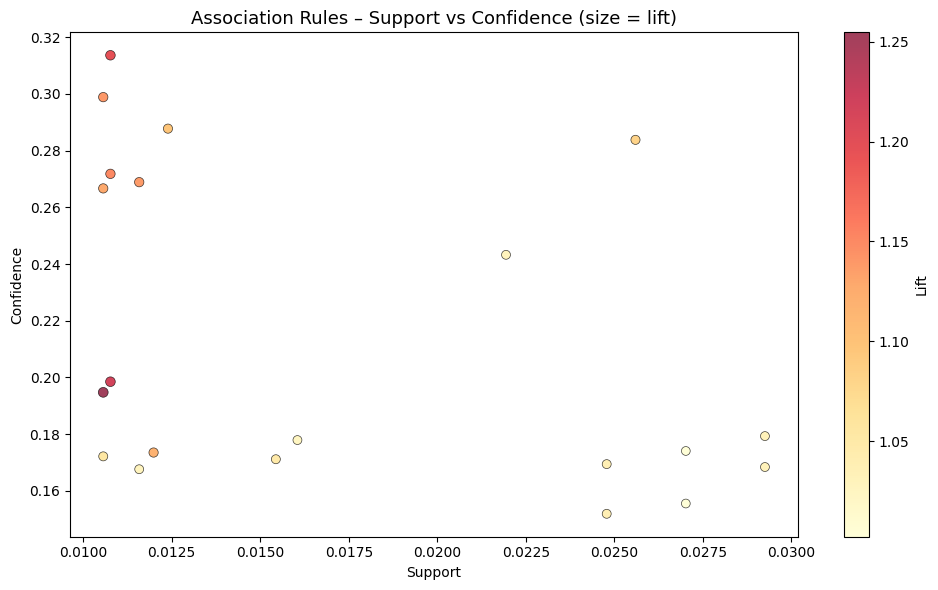

In [ ]:
# Lọc top rules (lift >= min_lift từ config)
top_rules = filter_top_rules(rules, min_lift=min_lift_cfg, top_n=30)
print(f"Top rules (lift >= {min_lift_cfg}): {len(top_rules)}")

# Lưu CSV
top_rules_csv = rules_to_csv_friendly(top_rules)
top_rules_csv.to_csv(os.path.join(tables_dir, "top_rules.csv"), index=False)
print(" Saved outputs/tables/top_rules.csv")

display(top_rules_csv[["antecedents", "consequents", "support", "confidence", "lift"]].head(15))

# Vẽ biểu đồ scatter: support vs confidence (size & color = lift)
if not top_rules.empty:
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    scatter = ax2.scatter(
        top_rules["support"],
        top_rules["confidence"],
        s=top_rules["lift"] * 40,
        c=top_rules["lift"],
        cmap="YlOrRd",
        alpha=0.75,
        edgecolors="black",
        linewidths=0.5,
    )
    plt.colorbar(scatter, label="Lift")
    ax2.set_title("Association Rules – Support vs Confidence (size = lift)", fontsize=13)
    ax2.set_xlabel("Support")
    ax2.set_ylabel("Confidence")
    plt.tight_layout()
    fig2.savefig(os.path.join(figures_dir, "rules_support_confidence.png"), dpi=150)
    print(" Saved outputs/figures/rules_support_confidence.png")
    plt.show()
else:
    print("⚠ Không có rules để vẽ biểu đồ")

# 7.Phân tích insight (combo sản phẩm)

In [ ]:
print("=" * 60)
print(" PHÂN TÍCH INSIGHT – COMBO SUB-CATEGORY")
print("=" * 60)

if not top_rules.empty:
    # Top 5 rules theo lift
    top5 = top_rules.head(5)
    for i, row in top5.iterrows():
        ant = ", ".join(sorted(row["antecedents"]))
        con = ", ".join(sorted(row["consequents"]))
        print(f"\n Rule {i+1}:")
        print(f"   {ant}  →  {con}")
        print(f"   Support    = {row['support']:.4f}")
        print(f"   Confidence = {row['confidence']:.4f}")
        print(f"   Lift       = {row['lift']:.4f}")

    print("\n" + "=" * 60)
    print("NHẬN XÉT:")
    print("  - Association rules ở mức Sub-Category (nhóm sản phẩm)")
    print("  - Các rules có lift > 1 cho thấy sub-category xuất hiện cùng nhau")
    print("    NHIỀU HƠN so với mua ngẫu nhiên.")
    print("  - Lift càng cao → mối liên kết càng mạnh → cơ hội cross-sell tốt.")
    print("  - Có thể dùng insight này để:")
    print("    • Đề xuất bundle / combo sản phẩm")
    print("    • Đặt các sub-category liên quan gần nhau trên kệ / web")
    print("    • Chạy promotion kết hợp")
    print("=" * 60)
else:
    print("⚠ Không có rules phù hợp để phân tích.")

📌 PHÂN TÍCH INSIGHT – COMBO SUB-CATEGORY

🔗 Rule 1:
   Binders, Paper  →  Storage
   Support    = 0.0106
   Confidence = 0.1948
   Lift       = 1.2547

🔗 Rule 2:
   Binders, Paper  →  Phones
   Support    = 0.0108
   Confidence = 0.1985
   Lift       = 1.2167

🔗 Rule 3:
   Paper, Phones  →  Binders
   Support    = 0.0108
   Confidence = 0.3136
   Lift       = 1.1957

🔗 Rule 4:
   Binders, Phones  →  Paper
   Support    = 0.0108
   Confidence = 0.2718
   Lift       = 1.1503

🔗 Rule 5:
   Paper, Storage  →  Binders
   Support    = 0.0106
   Confidence = 0.2989
   Lift       = 1.1394

💡 NHẬN XÉT:
  - Association rules ở mức Sub-Category (nhóm sản phẩm)
  - Các rules có lift > 1 cho thấy sub-category xuất hiện cùng nhau
    NHIỀU HƠN so với mua ngẫu nhiên.
  - Lift càng cao → mối liên kết càng mạnh → cơ hội cross-sell tốt.
  - Có thể dùng insight này để:
    • Đề xuất bundle / combo sản phẩm
    • Đặt các sub-category liên quan gần nhau trên kệ / web
    • Chạy promotion kết hợp
